<a href="https://colab.research.google.com/github/anthonyforde/diabetes/blob/main/Diabetes_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Import the libraries

In [308]:
import pandas as pd 
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
from scipy import stats
from patsy import dmatrices
from xgboost import XGBClassifier

from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as sm
import statsmodels.stats.stattools as st
import statsmodels.stats.api as sms
from statsmodels.api import add_constant

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import roc_curve, roc_auc_score, auc

## Bring in the data

### Mount Google Drive for analysis output

In [309]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/CA683I_DADM_Assignment")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Correlations.csv  Diabetes_v1.ipynb  pimaHist.jpg
count_plot.png	  Diabetes_v2.ipynb  ProfileReport.html


### Get raw data from Github

In [310]:
url = 'https://raw.githubusercontent.com/anthonyforde/diabetes/main/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
data_raw = pd.read_csv(url)
data_raw.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [311]:
data_raw.describe(include='all')

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,...,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,0.563458,0.525703,0.975259,29.856985,0.475273,0.062171,0.147810,0.703036,0.611795,...,0.954960,0.093914,2.837082,3.752037,5.810417,0.252730,0.456997,8.584055,4.920953,5.698311
std,0.500004,0.495960,0.499342,0.155336,7.113954,0.499392,0.241468,0.354914,0.456924,0.487345,...,0.207394,0.291712,1.113565,8.155627,10.062261,0.434581,0.498151,2.852153,1.029081,2.175196
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


### Check for missing data

In [312]:
data_raw.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

## Initial analysis - profile report

In [313]:
## pip install pandas-profiling[notebook]
## !pip3 install pandas_profiling --upgrade
#!pip install pandas-profiling==2.7.1 

In [314]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(data_raw)
##profile.to_notebook_iframe()
#profile.to_file(output_file="ProfileReport.html")

## Correlations

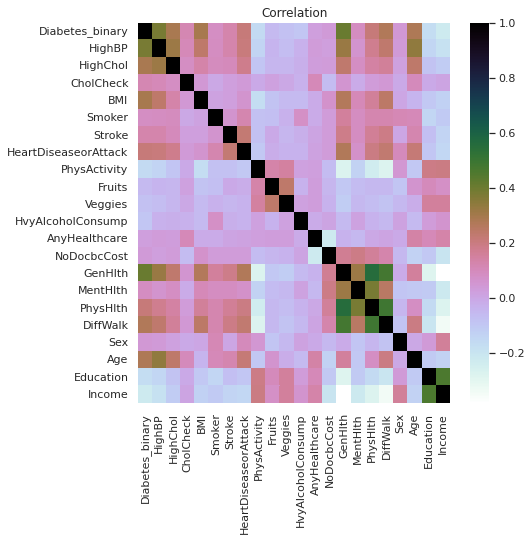

In [315]:
plt.figure(figsize=(7,7)) 
sns.heatmap(data_raw.corr(),annot=False,cmap='cubehelix_r')
plt.title('Correlation')
plt.show()

In [316]:
data_raw.corr()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_binary,1.000000,0.381516,0.289213,0.115382,0.293373,0.085999,0.125427,0.211523,-0.158666,-0.054077,...,0.023191,0.040977,0.407612,0.087029,0.213081,0.272646,0.044413,0.278738,-0.170481,-0.224449
HighBP,0.381516,1.000000,0.316515,0.103283,0.241019,0.087438,0.129060,0.210750,-0.136102,-0.040852,...,0.035764,0.026517,0.320540,0.064294,0.173922,0.234784,0.040819,0.338132,-0.141643,-0.187657
HighChol,0.289213,0.316515,1.000000,0.085981,0.131309,0.093398,0.099786,0.181187,-0.090453,-0.047384,...,0.031532,0.033199,0.237778,0.083881,0.142610,0.162043,0.017324,0.240338,-0.084386,-0.107777
CholCheck,0.115382,0.103283,0.085981,1.000000,0.045648,-0.004331,0.022529,0.043497,-0.008249,0.017384,...,0.106800,-0.062669,0.059213,-0.010660,0.034540,0.044430,-0.007991,0.101743,-0.008695,0.007550
BMI,0.293373,0.241019,0.131309,0.045648,1.000000,0.011551,0.022931,0.060355,-0.170936,-0.084505,...,-0.013417,0.065832,0.267888,0.104682,0.161862,0.246094,0.000827,-0.038648,-0.100233,-0.124878
Smoker,0.085999,0.087438,0.093398,-0.004331,0.011551,1.000000,0.064658,0.124418,-0.079823,-0.074811,...,-0.012939,0.035799,0.152416,0.091257,0.120698,0.119789,0.112125,0.105424,-0.140966,-0.104725
Stroke,0.125427,0.129060,0.099786,0.022529,0.022931,0.064658,1.000000,0.223394,-0.079985,-0.008996,...,0.006484,0.036198,0.189447,0.087303,0.164488,0.192266,0.003822,0.123879,-0.073926,-0.136577
HeartDiseaseorAttack,0.211523,0.210750,0.181187,0.043497,0.060355,0.124418,0.223394,1.000000,-0.098223,-0.019436,...,0.015687,0.036029,0.275868,0.075057,0.198416,0.232611,0.098161,0.221878,-0.096559,-0.146748
PhysActivity,-0.158666,-0.136102,-0.090453,-0.008249,-0.170936,-0.079823,-0.079985,-0.098223,1.000000,0.133813,...,0.027089,-0.063302,-0.273548,-0.130090,-0.234500,-0.276868,0.051753,-0.100753,0.190271,0.196551
Fruits,-0.054077,-0.040852,-0.047384,0.017384,-0.084505,-0.074811,-0.008996,-0.019436,0.133813,1.000000,...,0.029385,-0.045843,-0.098687,-0.062102,-0.048572,-0.050784,-0.088723,0.061096,0.098715,0.079009


In [317]:
data_raw.corr().to_csv("Correlations.csv")

## Check for multicollinearity

### Check for features with VIF > 10 and eliminate highest, one by one, until all VIF scores are < 10

In [318]:
# the independent variables set
data_temp = data_raw[['HighBP',	'HighChol',	'CholCheck',	'BMI', 'Smoker',	'Stroke',	'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data_temp.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data_temp.values, i)
                          for i in range(len(data_temp.columns))]
vif_data = vif_data.sort_values(by=['VIF'])  
print(vif_data)

                 feature        VIF
10     HvyAlcoholConsump   1.060520
5                 Stroke   1.164938
12           NoDocbcCost   1.213267
6   HeartDiseaseorAttack   1.393475
14              MentHlth   1.522342
17                   Sex   1.927069
4                 Smoker   2.032476
16              DiffWalk   2.068375
15              PhysHlth   2.252134
1               HighChol   2.479329
8                 Fruits   2.811279
0                 HighBP   3.034079
7           PhysActivity   3.726380
9                Veggies   4.993737
18                   Age  12.274687
13               GenHlth  12.946536
3                    BMI  17.752276
11         AnyHealthcare  20.097987
2              CholCheck  28.899936


#### Results show that, in descending order of VIF, the following features are > 10: CholCheck, AnyHealthcare, BMI, GenHlth, Age

### 1. Drop the highest VIF feature: CholCheck

In [319]:
data_temp = data_temp.drop(['CholCheck'], axis=1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data_temp.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data_temp.values, i)
                          for i in range(len(data_temp.columns))]
vif_data = vif_data.sort_values(by=['VIF'])
print(vif_data)

                 feature        VIF
9      HvyAlcoholConsump   1.059547
4                 Stroke   1.164938
11           NoDocbcCost   1.208946
5   HeartDiseaseorAttack   1.391307
13              MentHlth   1.521362
16                   Sex   1.919719
3                 Smoker   2.030934
15              DiffWalk   2.058478
14              PhysHlth   2.248227
1               HighChol   2.478179
7                 Fruits   2.796165
0                 HighBP   3.029276
6           PhysActivity   3.628317
8                Veggies   4.925922
17                   Age  11.499691
12               GenHlth  12.532249
2                    BMI  15.481397
10         AnyHealthcare  16.877671


#### Having dropped CholCheck, results show that, in descending order of VIF,  the following features are still > 10: AnyHealthcare, BMI, GenHlth, Age

### 2. Drop the next highest VIF feature: AnyHealthcare

In [320]:
data_temp = data_temp.drop(['AnyHealthcare'], axis=1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data_temp.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data_temp.values, i)
                          for i in range(len(data_temp.columns))]
vif_data = vif_data.sort_values(by=['VIF'])
print(vif_data)

                 feature        VIF
9      HvyAlcoholConsump   1.057489
4                 Stroke   1.164938
10           NoDocbcCost   1.187602
5   HeartDiseaseorAttack   1.387735
12              MentHlth   1.519254
15                   Sex   1.911404
3                 Smoker   2.029087
14              DiffWalk   2.050368
13              PhysHlth   2.247509
1               HighChol   2.478179
7                 Fruits   2.780487
0                 HighBP   3.006960
6           PhysActivity   3.471542
8                Veggies   4.806806
16                   Age   9.857512
11               GenHlth  12.255252
2                    BMI  12.729904


#### Having dropped CholCheck and AnyHealthcare, results show that, in descending order of VIF, the following features are still > 10: BMI, GenHlth and Age

### 3. Drop the next highest VIF feature: BMI

In [321]:
data_temp = data_temp.drop(['BMI'], axis=1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data_temp.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data_temp.values, i)
                          for i in range(len(data_temp.columns))]
vif_data = vif_data.sort_values(by=['VIF'])
print(vif_data)

                 feature       VIF
8      HvyAlcoholConsump  1.057335
3                 Stroke  1.161159
9            NoDocbcCost  1.183737
4   HeartDiseaseorAttack  1.369851
11              MentHlth  1.515010
14                   Sex  1.874174
2                 Smoker  2.028026
13              DiffWalk  2.041711
12              PhysHlth  2.223003
1               HighChol  2.471990
6                 Fruits  2.768614
0                 HighBP  2.974816
5           PhysActivity  3.354099
7                Veggies  4.556035
15                   Age  9.211652
10               GenHlth  9.748393


#### Having dropped CholCheck, AnyHealthcare and BMI, this has brought all VIF scores under 10 - let's go with this as the first cut of the dataset.

In [322]:
data_cut = data_raw.drop(['CholCheck', 'AnyHealthcare', 'BMI'], axis=1)
data_cut

,Diabetes_binary,HighBP,HighChol,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


## Split into different data types and categories

### Data types

Numeric independent variables are:
*   DISCRETE: MentHlth, PhysHlth
*   INTERVAL: Age
*   RATIO: Income

In [323]:
data_numeric = data_cut[['Diabetes_binary', 'MentHlth',	'PhysHlth',	'Age',	'Income']]
data_numeric

,Diabetes_binary,MentHlth,PhysHlth,Age,Income
0,0.0,5.0,30.0,4.0,8.0
1,0.0,0.0,0.0,12.0,8.0
2,0.0,0.0,10.0,13.0,8.0
3,0.0,0.0,3.0,11.0,8.0
4,0.0,0.0,0.0,8.0,8.0
...,...,...,...,...,...
70687,1.0,0.0,0.0,6.0,1.0
70688,1.0,0.0,0.0,10.0,6.0
70689,1.0,15.0,0.0,13.0,4.0
70690,1.0,0.0,0.0,11.0,4.0


Categorical independent variables are:
*   NOMINAL: HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex
*   ORDINAL: GenHlth, Education


In [324]:
data_categorical = data_cut.drop(['MentHlth',	'PhysHlth',	'Age',	'Income'], axis=1)
data_categorical

,Diabetes_binary,HighBP,HighChol,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,DiffWalk,Sex,Education
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,6.0
1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,6.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,6.0
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,6.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,4.0
70688,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,3.0
70689,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0,6.0
70690,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,2.0


### Data Categories

#### Now let's categorise our variables into different groups

HEALTH: GenHlth, MentHlth, PhysHlth, DiffWalk


In [325]:
data_health = data_cut[['GenHlth',	'MentHlth',	'PhysHlth',	'DiffWalk']]
data_health

,GenHlth,MentHlth,PhysHlth,DiffWalk
0,3.0,5.0,30.0,0.0
1,3.0,0.0,0.0,0.0
2,1.0,0.0,10.0,0.0
3,3.0,0.0,3.0,0.0
4,2.0,0.0,0.0,0.0
...,...,...,...,...
70687,4.0,0.0,0.0,0.0
70688,2.0,0.0,0.0,1.0
70689,5.0,15.0,0.0,1.0
70690,4.0,0.0,0.0,1.0


LIFESTYLE: Smoker, PhysActivity, Fruits, Veggies, HvyAlcoholConsump


In [326]:
data_lifestyle = data_cut[['Smoker',	'PhysActivity',	'Fruits',	'Veggies', 'HvyAlcoholConsump']]
data_lifestyle

,Smoker,PhysActivity,Fruits,Veggies,HvyAlcoholConsump
0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...
70687,0.0,0.0,0.0,1.0,0.0
70688,1.0,0.0,1.0,1.0,0.0
70689,0.0,0.0,1.0,0.0,0.0
70690,0.0,0.0,0.0,0.0,0.0


MEDICAL: GenHlth, MentHlth, PhysHlth, DiffWalk

In [327]:
data_medical = data_cut[['GenHlth',	'MentHlth', 'PhysHlth', 'DiffWalk']]
data_medical

,GenHlth,MentHlth,PhysHlth,DiffWalk
0,3.0,5.0,30.0,0.0
1,3.0,0.0,0.0,0.0
2,1.0,0.0,10.0,0.0
3,3.0,0.0,3.0,0.0
4,2.0,0.0,0.0,0.0
...,...,...,...,...
70687,4.0,0.0,0.0,0.0
70688,2.0,0.0,0.0,1.0
70689,5.0,15.0,0.0,1.0
70690,4.0,0.0,0.0,1.0


SOCIOECONOMIC: Education, Income

In [328]:
data_socioeconomic = data_cut[['Education',	'Income']]
data_socioeconomic

,Education,Income
0,6.0,8.0
1,6.0,8.0
2,6.0,8.0
3,6.0,8.0
4,5.0,8.0
...,...,...
70687,4.0,1.0
70688,3.0,6.0
70689,6.0,4.0
70690,2.0,4.0


## Categorical data tests - Chi-Square

#### Function to calculate p-value for a binary feature parameter

These features have values [1, 0], e.g. denoting [Y, N], [Female, Male], etc.

Example:

>Diabetes Flag | 	# IV values 0 | #	IV values 1
>--- | --- | --- 
>0 | 80	| 220 
>1| 50	| 5 
 

In [329]:
# Create a new dataframe to hold Chi-Square scores for each feature
chi_sq_scores = []
chi_sq_scores = pd.DataFrame(columns = ['Feature', 'Chi_Sq_Stat', 'P_Value'])

In [330]:
def calcPValueBinary(independent_variable, chi_sq_scores):

  # Temp copy of main scores dataframe. To be used for scores processing - we return calculations out of this function to main scores dataframe1.
  # Python can be tempermental about passing dataframes as pararmeters and updating within functions.
  temp_df = chi_sq_scores.copy()

  diabetes_N0_var_N0 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 0)]['Diabetes_binary'].count()
  diabetes_N0_var_Y1 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
  diabetes_Y1_var_N0 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 0)]['Diabetes_binary'].count()
  diabetes_Y1_var_Y1 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()

  print("Independent variable: " + independent_variable)
  # print("Diabetes N, Var N: " + str(diabetes_N0_var_N0))
  # print("Diabetes N, Var Y: " + str(diabetes_N0_var_Y1))
  # print("Diabetes Y, Var N: " + str(diabetes_Y1_var_N0))
  # print("Diabetes Y, Var Y: " + str(diabetes_Y1_var_Y1))

  diabetes_N0 = [diabetes_N0_var_N0, diabetes_N0_var_Y1]
  diabetes_Y1 = [diabetes_Y1_var_N0, diabetes_Y1_var_Y1]
  diabetes = np.array([diabetes_N0, diabetes_Y1])
  chi2_stat, p_val, dof, ex = stats.chi2_contingency(diabetes)
  print("=== P-Value: " + str(p_val))
  print("=== chi2_stat: " + str(chi2_stat))

  # Add result to the overall Chi Square results - for feature analysis
  new_score_results_row  = {'Feature': independent_variable, 'Chi_Sq_Stat': chi2_stat, 'P_Value': p_val}
  temp_df = temp_df.append(new_score_results_row, ignore_index=True)

  return temp_df

In [331]:
chi_sq_scores

,Feature,Chi_Sq_Stat,P_Value


#### Binary categorical features

Read all binary feature names into array

In [332]:
binary_features = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 
                   'Fruits', 'Veggies', 'HvyAlcoholConsump', 'NoDocbcCost', 'DiffWalk', 'Sex']

Calculate p-values for each binary variable and output to scores table

In [333]:
for i in binary_features:
  chi_sq_scores = calcPValueBinary(i, chi_sq_scores)

Independent variable: HighBP
=== P-Value: 0.0
=== chi2_stat: 10287.972984997781
Independent variable: HighChol
=== P-Value: 0.0
=== chi2_stat: 5911.8066998822505
Independent variable: Smoker
=== P-Value: 1.2211053080400827e-115
=== chi2_stat: 522.4810772937883
Independent variable: Stroke
=== P-Value: 1.290837098922016e-243
=== chi2_stat: 1111.0793074560897
Independent variable: HeartDiseaseorAttack
=== P-Value: 0.0
=== chi2_stat: 3161.7202445322782
Independent variable: PhysActivity
=== P-Value: 0.0
=== chi2_stat: 1778.9607035956992
Independent variable: Fruits
=== P-Value: 7.967064756507964e-47
=== chi2_stat: 206.50090830615105
Independent variable: Veggies
=== P-Value: 1.4007103685991128e-98
=== chi2_stat: 444.0806516898606
Independent variable: HvyAlcoholConsump
=== P-Value: 3.9133962745676324e-140
=== chi2_stat: 635.0865339749427
Independent variable: NoDocbcCost
=== P-Value: 1.4053255735064045e-27
=== chi2_stat: 118.4167174482265
Independent variable: DiffWalk
=== P-Value: 0.0
==

#### General Health
This is an ordinal feature with five possible values 1-5. Can't use the binary calculation function - creating a custom calculation for 5 values.

In [334]:
independent_variable = "GenHlth"

diabetes_N0_var_1 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_N0_var_2 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 2)]['Diabetes_binary'].count()
diabetes_N0_var_3 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 3)]['Diabetes_binary'].count()
diabetes_N0_var_4 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 4)]['Diabetes_binary'].count()
diabetes_N0_var_5 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 5)]['Diabetes_binary'].count()
diabetes_Y1_var_1 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_Y1_var_2 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 2)]['Diabetes_binary'].count()
diabetes_Y1_var_3 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 3)]['Diabetes_binary'].count()
diabetes_Y1_var_4 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 4)]['Diabetes_binary'].count()
diabetes_Y1_var_5 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 5)]['Diabetes_binary'].count()

print("Independent variable: " + independent_variable)
# print("Diabetes N, Var 1: " + str(diabetes_N0_var_1))
# print("Diabetes N, Var 2: " + str(diabetes_N0_var_2))
# print("Diabetes N, Var 3: " + str(diabetes_N0_var_3))
# print("Diabetes N, Var 4: " + str(diabetes_N0_var_4))
# print("Diabetes N, Var 5: " + str(diabetes_N0_var_5))
# print("Diabetes Y, Var 1: " + str(diabetes_Y1_var_1))
# print("Diabetes Y, Var 2: " + str(diabetes_Y1_var_2))
# print("Diabetes Y, Var 3: " + str(diabetes_Y1_var_3))
# print("Diabetes Y, Var 4: " + str(diabetes_Y1_var_4))
# print("Diabetes Y, Var 5: " + str(diabetes_Y1_var_5))

diabetes_N0 = [diabetes_N0_var_1, diabetes_N0_var_2, diabetes_N0_var_3, diabetes_N0_var_4, diabetes_N0_var_5]
diabetes_Y1 = [diabetes_Y1_var_1, diabetes_Y1_var_2, diabetes_Y1_var_3, diabetes_Y1_var_4, diabetes_Y1_var_5]
diabetes = np.array([diabetes_N0, diabetes_Y1])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(diabetes)
print("=== chi2_stat: " + str(p_val))
print("=== P-Value: " + str(p_val))

# Add result to the overall Chi Square results - for feature analysis
new_score_results_row  = {'Feature': independent_variable, 'Chi_Sq_Stat': chi2_stat, 'P_Value': p_val}
chi_sq_scores = chi_sq_scores.append(new_score_results_row, ignore_index=True)

Independent variable: GenHlth
=== chi2_stat: 0.0
=== P-Value: 0.0


#### Education
This is an ordinal feature with six possible values 1-6. Can't use the binary calculation function - creating a custom calculation for 6 values.

In [335]:
independent_variable = "Education"

diabetes_N0_var_1 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_N0_var_2 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 2)]['Diabetes_binary'].count()
diabetes_N0_var_3 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 3)]['Diabetes_binary'].count()
diabetes_N0_var_4 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 4)]['Diabetes_binary'].count()
diabetes_N0_var_5 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 5)]['Diabetes_binary'].count()
diabetes_N0_var_6 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 6)]['Diabetes_binary'].count()
diabetes_Y1_var_1 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_Y1_var_2 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 2)]['Diabetes_binary'].count()
diabetes_Y1_var_3 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 3)]['Diabetes_binary'].count()
diabetes_Y1_var_4 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 4)]['Diabetes_binary'].count()
diabetes_Y1_var_5 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 5)]['Diabetes_binary'].count()
diabetes_Y1_var_6 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 6)]['Diabetes_binary'].count()

print("Independent variable: " + independent_variable)
print("Diabetes N, Var 1: " + str(diabetes_N0_var_1))
print("Diabetes N, Var 2: " + str(diabetes_N0_var_2))
print("Diabetes N, Var 3: " + str(diabetes_N0_var_3))
print("Diabetes N, Var 4: " + str(diabetes_N0_var_4))
print("Diabetes N, Var 5: " + str(diabetes_N0_var_5))
print("Diabetes N, Var 6: " + str(diabetes_N0_var_6))
print("Diabetes Y, Var 1: " + str(diabetes_Y1_var_1))
print("Diabetes Y, Var 2: " + str(diabetes_Y1_var_2))
print("Diabetes Y, Var 3: " + str(diabetes_Y1_var_3))
print("Diabetes Y, Var 4: " + str(diabetes_Y1_var_4))
print("Diabetes Y, Var 5: " + str(diabetes_Y1_var_5))
print("Diabetes Y, Var 6: " + str(diabetes_Y1_var_6))

diabetes_N0 = [diabetes_N0_var_1, diabetes_N0_var_2, diabetes_N0_var_3, diabetes_N0_var_4, diabetes_N0_var_5]
diabetes_Y1 = [diabetes_Y1_var_1, diabetes_Y1_var_2, diabetes_Y1_var_3, diabetes_Y1_var_4, diabetes_Y1_var_5]
diabetes = np.array([diabetes_N0, diabetes_Y1])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(diabetes)
print("=== chi2_stat: " + str(p_val))
print("=== P-Value: " + str(p_val))

# Add result to the overall Chi Square results - for feature analysis
new_score_results_row  = {'Feature': independent_variable, 'Chi_Sq_Stat': chi2_stat, 'P_Value': p_val}
chi_sq_scores = chi_sq_scores.append(new_score_results_row, ignore_index=True)

Independent variable: Education
Diabetes N, Var 1: 28
Diabetes N, Var 2: 464
Diabetes N, Var 3: 1151
Diabetes N, Var 4: 8407
Diabetes N, Var 5: 9676
Diabetes N, Var 6: 15620
Diabetes Y, Var 1: 47
Diabetes Y, Var 2: 1183
Diabetes Y, Var 3: 2296
Diabetes Y, Var 4: 11066
Diabetes Y, Var 5: 10354
Diabetes Y, Var 6: 10400
=== chi2_stat: 6.15764388347325e-103
=== P-Value: 6.15764388347325e-103


#### Final Chi-Square scores

Here we can see the Chi-Squares results in descending order of Chi-Square Stat scores - highest or most "important" features at the top

In [336]:
f = plt.figure()
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [337]:
chi_sq_scores = chi_sq_scores.sort_values(by='Chi_Sq_Stat', ascending=False)
chi_sq_scores

,Feature,Chi_Sq_Stat,P_Value
12,GenHlth,12304.318980,0.000000e+00
0,HighBP,10287.972985,0.000000e+00
1,HighChol,5911.806700,0.000000e+00
10,DiffWalk,5253.694843,0.000000e+00
4,HeartDiseaseorAttack,3161.720245,0.000000e+00
5,PhysActivity,1778.960704,0.000000e+00
3,Stroke,1111.079307,1.290837e-243
8,HvyAlcoholConsump,635.086534,3.913396e-140
2,Smoker,522.481077,1.221105e-115
13,Education,481.673667,6.157644e-103


In [338]:
features = chi_sq_scores['Feature']
features

12                 GenHlth
0                   HighBP
1                 HighChol
10                DiffWalk
4     HeartDiseaseorAttack
5             PhysActivity
3                   Stroke
8        HvyAlcoholConsump
2                   Smoker
13               Education
7                  Veggies
6                   Fruits
11                     Sex
9              NoDocbcCost
Name: Feature, dtype: object

In [339]:
scores = chi_sq_scores['Chi_Sq_Stat']
scores

12    12304.318980
0     10287.972985
1      5911.806700
10     5253.694843
4      3161.720245
5      1778.960704
3      1111.079307
8       635.086534
2       522.481077
13      481.673667
7       444.080652
6       206.500908
11      139.261855
9       118.416717
Name: Chi_Sq_Stat, dtype: float64

In [340]:
y_axis = scores.to_numpy()

In [341]:
x_axis = features.to_numpy()

In [342]:
f = plt.figure()

<Figure size 432x288 with 0 Axes>

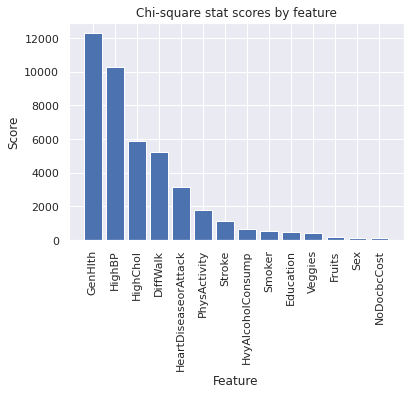

In [343]:
f.set_figwidth(10)
f.set_figheight(5)
plt.bar(x_axis, y_axis)
plt.xticks(rotation=90)
plt.title('Chi-square stat scores by feature')
plt.xlabel('Feature')
plt.ylabel('Score')
plt.show()

#### Let's take a further look at some high scoring and interesting features

**General Health:** This is the highest scoring feature, an ordinal variable. We can see an obvious correlation with diabetes, diabetics are more likely to suffer from poorer general health.

1 = excellent

2 = very good

3 = good

4 = fair

5 = poor

In [344]:
independent_variable = "GenHlth"

diabetes_N0_var_1 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_N0_var_2 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 2)]['Diabetes_binary'].count()
diabetes_N0_var_3 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 3)]['Diabetes_binary'].count()
diabetes_N0_var_4 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 4)]['Diabetes_binary'].count()
diabetes_N0_var_5 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 5)]['Diabetes_binary'].count()
diabetes_Y1_var_1 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_Y1_var_2 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 2)]['Diabetes_binary'].count()
diabetes_Y1_var_3 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 3)]['Diabetes_binary'].count()
diabetes_Y1_var_4 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 4)]['Diabetes_binary'].count()
diabetes_Y1_var_5 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 5)]['Diabetes_binary'].count()

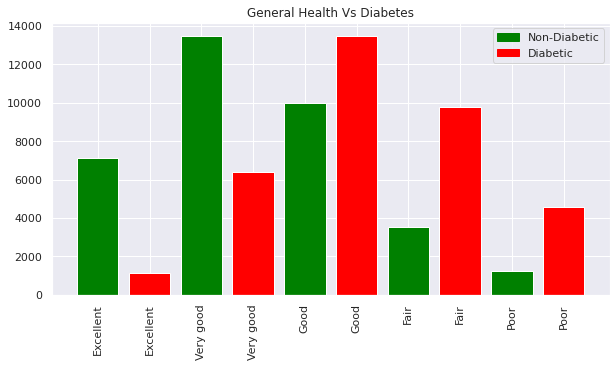

In [345]:
width1 = 10
height1 = 5
width_height_1 = (width1, height1)

plt.figure(figsize=width_height_1)

plt.xticks(rotation=90)

ax = fig.add_axes([0,0,1,1])
x_axis = ['Excellent', 'Excellent', 'Very good', 'Very good', 'Good', 'Good', 'Fair', 'Fair', 'Poor', 'Poor']
y_axis = [diabetes_N0_var_1 ,diabetes_Y1_var_1, diabetes_N0_var_2, diabetes_Y1_var_2, diabetes_N0_var_3, diabetes_Y1_var_3,
          diabetes_N0_var_4, diabetes_Y1_var_4, diabetes_N0_var_5, diabetes_Y1_var_5]

x_pos = np.arange(len(x_axis))

# Create bars with different colors
plt.bar(x_pos, y_axis, color=['green', 'red', 'green', 'red', 'green', 'red', 'green', 'red', 'green', 'red'])
# Create names on the x-axis
plt.xticks(x_pos, x_axis)

green_patch = mpatches.Patch(color='green', label='Non-Diabetic')
red_patch = mpatches.Patch(color='red', label='Diabetic')
plt.legend(handles=[green_patch, red_patch])
plt.title('General Health Vs Diabetes')

plt.show()

In [346]:
xindependent_variable = "HighBP"

diabetes_N0_var_N0 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 0)]['Diabetes_binary'].count()
diabetes_N0_var_Y1 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_Y1_var_N0 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 0)]['Diabetes_binary'].count()
diabetes_Y1_var_Y1 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()

**High blood pressure:** The higest scoring binarty feature - again another obvious correlation with diabetes.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


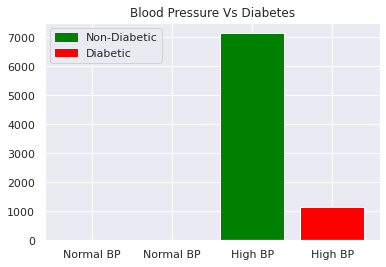

In [347]:
ax = fig.add_axes([0,0,1,1])
x_axis = ['Normal BP', 'Normal BP', 'High BP', 'High BP']
y_axis = [diabetes_N0_var_N0 ,diabetes_Y1_var_N0, diabetes_N0_var_Y1, diabetes_Y1_var_Y1]

x_pos = np.arange(len(x_axis))

# Create bars with different colors
plt.bar(x_pos, y_axis, color=['green', 'red', 'green', 'red'])
# Create names on the x-axis
plt.xticks(x_pos, x_axis)

green_patch = mpatches.Patch(color='green', label='Non-Diabetic')
red_patch = mpatches.Patch(color='red', label='Diabetic')
plt.legend(handles=[green_patch, red_patch])
plt.title('Blood Pressure Vs Diabetes')


plt.show()

**Education:** Another ordinal variable, not as influential as general health or high cholesterol above. However, there is some evidence to suggest people with higher education are less likely to suffer from diabetes.

1 = Never attended school or only kindergarten

2 = Grades 1 through 8 (Elementary)

3 = Grades 9 through 11 (Some high school)

4 = Grade 12 or GED (High school graduate)

5 = College 1 year to 3 years (Some college or technical school)

6 = College 4 years or more (College graduate)

In [348]:
independent_variable = "Education"

diabetes_N0_var_1 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_N0_var_2 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 2)]['Diabetes_binary'].count()
diabetes_N0_var_3 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 3)]['Diabetes_binary'].count()
diabetes_N0_var_4 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 4)]['Diabetes_binary'].count()
diabetes_N0_var_5 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 5)]['Diabetes_binary'].count()
diabetes_N0_var_6 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 6)]['Diabetes_binary'].count()
diabetes_Y1_var_1 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_Y1_var_2 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 2)]['Diabetes_binary'].count()
diabetes_Y1_var_3 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 3)]['Diabetes_binary'].count()
diabetes_Y1_var_4 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 4)]['Diabetes_binary'].count()
diabetes_Y1_var_5 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 5)]['Diabetes_binary'].count()
diabetes_Y1_var_6 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 6)]['Diabetes_binary'].count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


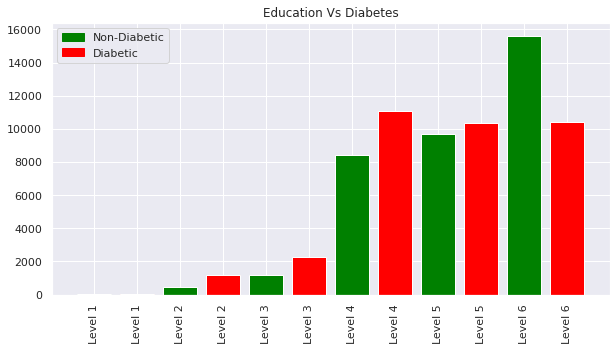

In [349]:
width1 = 10
height1 = 5
width_height_1 = (width1, height1)

plt.figure(figsize=width_height_1)

ax = fig.add_axes([0,0,1,1])
x_axis = ['Level 1', 'Level 1', 'Level 2', 'Level 2', 'Level 3', 'Level 3', 'Level 4', 'Level 4', 'Level 5', 'Level 5', 'Level 6', 'Level 6']
y_axis = [diabetes_N0_var_1 ,diabetes_Y1_var_1, diabetes_N0_var_2, diabetes_Y1_var_2, diabetes_N0_var_3, diabetes_Y1_var_3,
          diabetes_N0_var_4, diabetes_Y1_var_4, diabetes_N0_var_5, diabetes_Y1_var_5, diabetes_N0_var_6, diabetes_Y1_var_6]

x_pos = np.arange(len(x_axis))

# Create bars with different colors
plt.bar(x_pos, y_axis, color=['green', 'red', 'green', 'red', 'green', 'red', 'green', 'red', 'green', 'red', 'green', 'red'])
# Create names on the x-axis
plt.xticks(x_pos, x_axis)
plt.xticks(rotation=90)
plt.title('Education Vs Diabetes')

green_patch = mpatches.Patch(color='green', label='Non-Diabetic')
red_patch = mpatches.Patch(color='red', label='Diabetic')
plt.legend(handles=[green_patch, red_patch])

plt.show()

**Gender:** Just taking a look out of interest. Even though it doesn't rate much against most other features in the Chi-Square Stats, you can still see the imbalance of female Vs male.

In [350]:
independent_variable = "Sex"

diabetes_N0_var_F0 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 0)]['Diabetes_binary'].count()
diabetes_N0_var_M1 = data_cut[(data_cut['Diabetes_binary'] == 0) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()
diabetes_Y1_var_F0 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 0)]['Diabetes_binary'].count()
diabetes_Y1_var_M1 = data_cut[(data_cut['Diabetes_binary'] == 1) & (data_cut[independent_variable] == 1)]['Diabetes_binary'].count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


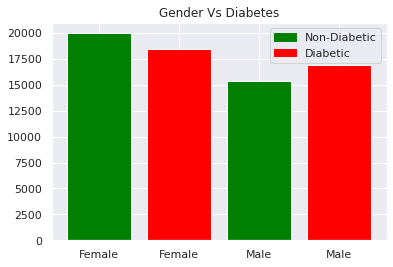

In [351]:
ax = fig.add_axes([0,0,1,1])
x_axis = ['Female', 'Female', 'Male', 'Male']
y_axis = [diabetes_N0_var_F0, diabetes_Y1_var_F0, diabetes_N0_var_M1, diabetes_Y1_var_M1]

x_pos = np.arange(len(x_axis))

# Create bars with different colors
plt.bar(x_pos, y_axis, color=['green', 'red', 'green', 'red'])
# Create names on the x-axis
plt.xticks(x_pos, x_axis)

green_patch = mpatches.Patch(color='green', label='Non-Diabetic')
red_patch = mpatches.Patch(color='red', label='Diabetic')
plt.legend(handles=[green_patch, red_patch])
plt.title('Gender Vs Diabetes')


plt.show()

## Numeric data  tests - Logistic Regression

### Read in our data_numeric dataset

In [352]:
data_numeric

,Diabetes_binary,MentHlth,PhysHlth,Age,Income
0,0.0,5.0,30.0,4.0,8.0
1,0.0,0.0,0.0,12.0,8.0
2,0.0,0.0,10.0,13.0,8.0
3,0.0,0.0,3.0,11.0,8.0
4,0.0,0.0,0.0,8.0,8.0
...,...,...,...,...,...
70687,1.0,0.0,0.0,6.0,1.0
70688,1.0,0.0,0.0,10.0,6.0
70689,1.0,15.0,0.0,13.0,4.0
70690,1.0,0.0,0.0,11.0,4.0


In [353]:
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

data_numeric.describe()

,Diabetes_binary,MentHlth,PhysHlth,Age,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,3.752037,5.810417,8.584055,5.698311
std,0.500004,8.155627,10.062261,2.852153,2.175196
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,7.000000,4.000000
50%,0.500000,0.000000,0.000000,9.000000,6.000000
75%,1.000000,2.000000,6.000000,11.000000,8.000000
max,1.000000,30.000000,30.000000,13.000000,8.000000


Show that it's balanced - even diabetes Y/N

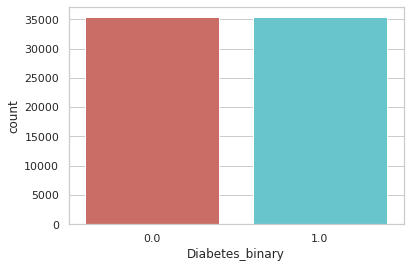

<Figure size 432x288 with 0 Axes>

In [354]:
sns.countplot(x='Diabetes_binary',data=data_numeric,palette='hls')
plt.show()
plt.savefig('count_plot')

Let's check correlations

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


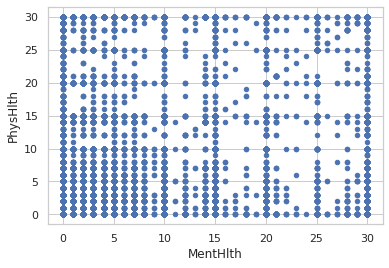

In [355]:
data_numeric.plot.scatter(x='MentHlth', y='PhysHlth')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


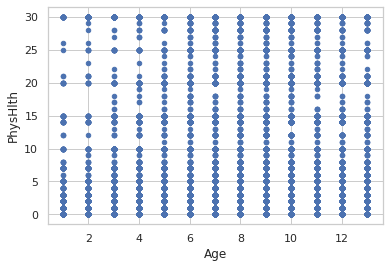

In [356]:
data_numeric.plot.scatter(x='Age', y='PhysHlth')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


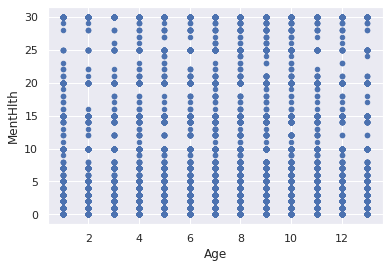

In [357]:
sns.set()
%matplotlib inline
data_numeric.plot.scatter(x='Age', y='MentHlth')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


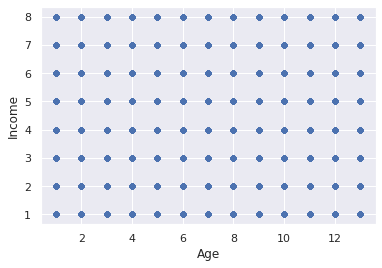

In [358]:
data_numeric.plot.scatter(x='Age', y='Income')

In [359]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant
corr = data_numeric[['MentHlth','PhysHlth','Age', 'Income']].corr()
corr.style.background_gradient(cmap='coolwarm')

,MentHlth,PhysHlth,Age,Income
MentHlth,1.000000,0.380272,-0.101746,-0.219070
PhysHlth,0.380272,1.000000,0.084852,-0.279326
Age,-0.101746,0.084852,1.000000,-0.130140
Income,-0.219070,-0.279326,-0.130140,1.000000


There is some correlation between between age and physical health, as expected, so let's do a futher check for multicollinearity using VIF to be certain.

In [360]:
X=data_numeric[['MentHlth','PhysHlth','Age', 'Income']]
X = add_constant(X)
y=data_numeric['Diabetes_binary']
vif = [variance_inflation_factor(X.to_numpy(), i) for i in range(X.to_numpy().shape[1])]

print(vif[1:])

[1.2202116759699817, 1.240334820900413, 1.0473162869688768, 1.1220361886411128]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


As we can see, there's no VIF > 10 and, in fact, all approximately 1 so we're good to use all four independent variables for our logistic regression.

### Run logistic regression models

In [361]:
import statsmodels.api as sm
 
import statsmodels.discrete.discrete_model as sml

X=data_numeric[['MentHlth','PhysHlth','Age', 'Income']]
logit = sml.Logit(y, X).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.626808
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:                70692
Model:                          Logit   Df Residuals:                    70688
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Apr 2022   Pseudo R-squ.:                 0.09571
Time:                        16:41:52   Log-Likelihood:                -44310.
converged:                       True   LL-Null:                       -49000.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MentHlth      -0.0003      0.001     -0.261      0.794      -0.002       0.002
PhysHlth       0.0289      0.

High level scores at a glance:

*   LLR p-value is is signficant (0 < 0.05) which tells us our logistic regression is better than null model.
*   However, we don't have a great pseudo r-squared value of 0.0957: this should ideally be between 0.2 and 0.4 for a good result.

We need to run a confusion matrix to get more information.



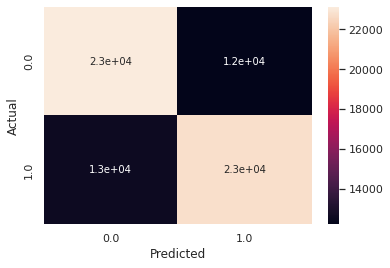

In [362]:
confusion_matrix = pd.crosstab(y, np.round_(logit.predict(),0), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

Looking at the confusion matrix, the approximate breakdown % of TP, TN, FP, FN is:

32.5, 32.5, 18, 17

This is not great.

Let's run some accuracy stats...

In [363]:
from sklearn.metrics import classification_report
print(classification_report(y, np.round_(logit.predict(),0)))

              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65     35346
         1.0       0.65      0.64      0.65     35346

    accuracy                           0.65     70692
   macro avg       0.65      0.65      0.65     70692
weighted avg       0.65      0.65      0.65     70692



As expected, precision only 65%, as is the f1-score.

**Conclusion:** Logisitic regression model for these features is better than nothing but not good enough for reliable prediction

### Tweak the data and retest - remove Mental Health (bad scoring p-value)

In [364]:
X=data_numeric[['PhysHlth', 'Age', 'Income']]
logit = sml.Logit(y, X).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.626809
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:                70692
Model:                          Logit   Df Residuals:                    70689
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Apr 2022   Pseudo R-squ.:                 0.09571
Time:                        16:41:53   Log-Likelihood:                -44310.
converged:                       True   LL-Null:                       -49000.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PhysHlth       0.0288      0.001     34.044      0.000       0.027       0.031
Age            0.1375      0.

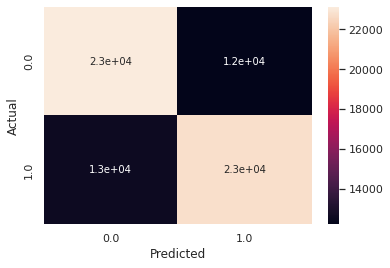

In [365]:
confusion_matrix = pd.crosstab(y, np.round_(logit.predict(),0), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [366]:
from sklearn.metrics import classification_report
print(classification_report(y, np.round_(logit.predict(),0)))

              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65     35346
         1.0       0.65      0.64      0.65     35346

    accuracy                           0.65     70692
   macro avg       0.65      0.65      0.65     70692
weighted avg       0.65      0.65      0.65     70692



**Conclusion:** Results not any better, let's go with original evaluation, i.e. logistical regression not great for this model.

### Tweak the data and retest - remove Age (highly correlated with income)

In [367]:
X=data_numeric[['MentHlth','PhysHlth','Income']]
logit = sml.Logit(y, X).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.661868
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:                70692
Model:                          Logit   Df Residuals:                    70689
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Apr 2022   Pseudo R-squ.:                 0.04513
Time:                        16:41:54   Log-Likelihood:                -46789.
converged:                       True   LL-Null:                       -49000.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MentHlth       0.0027      0.001      2.559      0.010       0.001       0.005
PhysHlth       0.0458      0.

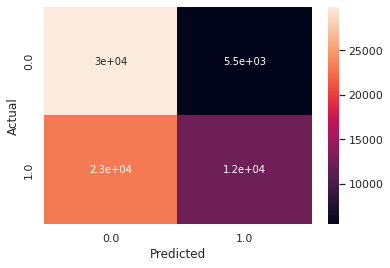

In [368]:
confusion_matrix = pd.crosstab(y, np.round_(logit.predict(),0), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [369]:
from sklearn.metrics import classification_report
print(classification_report(y, np.round_(logit.predict(),0)))

              precision    recall  f1-score   support

         0.0       0.56      0.85      0.68     35346
         1.0       0.69      0.35      0.46     35346

    accuracy                           0.60     70692
   macro avg       0.63      0.60      0.57     70692
weighted avg       0.63      0.60      0.57     70692



**Conclusion:** Results not any better, let's go with original evaluation, i.e. logistical regression not great for this model.

### Tweak the data and retest - remove Income (highly correlated with Age)

In [370]:
X=data_numeric[['MentHlth','PhysHlth','Age']]
logit = sml.Logit(y, X).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.675355
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:                70692
Model:                          Logit   Df Residuals:                    70689
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Apr 2022   Pseudo R-squ.:                 0.02567
Time:                        16:41:54   Log-Likelihood:                -47742.
converged:                       True   LL-Null:                       -49000.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MentHlth      -0.0048      0.001     -4.713      0.000      -0.007      -0.003
PhysHlth       0.0363      0.

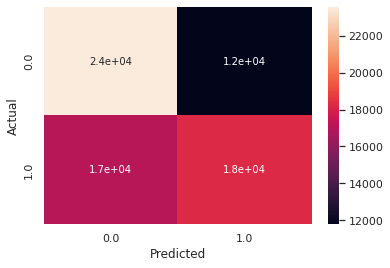

In [371]:
confusion_matrix = pd.crosstab(y, np.round_(logit.predict(),0), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [372]:
from sklearn.metrics import classification_report
print(classification_report(y, np.round_(logit.predict(),0)))

              precision    recall  f1-score   support

         0.0       0.58      0.67      0.62     35346
         1.0       0.61      0.52      0.56     35346

    accuracy                           0.59     70692
   macro avg       0.59      0.59      0.59     70692
weighted avg       0.59      0.59      0.59     70692



**Conclusion:** Results not any better, let's go with original evaluation, i.e. logistical regression not great for this model.

## Prediction Models - WIP

### Split the dataset

In [385]:
X = data_cut.drop(['Diabetes_binary'], axis=1)
y = data_cut['Diabetes_binary']

In [386]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

### MODEL: Decision Tree Classifier

In [387]:
from sklearn import tree                                # 1. Choose model class
model = tree.DecisionTreeClassifier()                   # 2. Instantiate model
model.fit(Xtrain, ytrain)                               # 3. Fit model to data
ytrain_model = model.predict(Xtrain)                    # 4. Predict on training data
ytest_model = model.predict(Xtest)                      # 5. Predict on test data

In [388]:
from sklearn.metrics import f1_score,accuracy_score

DTC_train_accuracy = accuracy_score(ytrain, ytrain_model)
DTC_train_f1_score = f1_score(ytrain, ytrain_model,average='weighted')
print("--- DTC Training metrics ---")
print("F1-Score: ", DTC_train_f1_score*100)
print("Accuracy Score: ", DTC_train_accuracy*100)

DTC_test_accuracy = accuracy_score(ytest, ytest_model)
DTC_test_f1_score = f1_score(ytest, ytest_model,average='weighted')
print("--- DTC Testing metrics ---")
print("F1-Score: ", DTC_test_f1_score*100)
print("Accuracy Score: ", DTC_test_accuracy*100)

--- DTC Training metrics ---
F1-Score:  96.69571629349754
Accuracy Score:  96.69690378936573
--- DTC Testing metrics ---
F1-Score:  65.41608851748568
Accuracy Score:  65.44310064360988


### MODEL: Naive Bayes

In [389]:
from sklearn.naive_bayes import GaussianNB    # 1. Choose model class
model = GaussianNB()                          # 2. Instantiate model
model.fit(Xtrain, ytrain)                     # 3. Fit model to data
ytrain_model = model.predict(Xtrain)          # 4. Predict on training data
ytest_model = model.predict(Xtest)            # 5. Predict on test data

In [390]:
from sklearn.metrics import f1_score,accuracy_score

GNB_train_accuracy = accuracy_score(ytrain, ytrain_model)
GNB_train_f1_score = f1_score(ytrain, ytrain_model,average='weighted')
print("--- GNB Training metrics ---")
print("F1-Score: ", GNB_train_f1_score*100)
print("Accuracy Score: ", GNB_train_accuracy*100)

GNB_test_accuracy = accuracy_score(ytest, ytest_model)
GNB_test_f1_score = f1_score(ytest, ytest_model,average='weighted')
print("--- GNB Testing metrics ---")
print("F1-Score: ", GNB_test_f1_score*100)
print("Accuracy Score: ", GNB_test_accuracy*100)

--- GNB Training metrics ---
F1-Score:  69.48429575651578
Accuracy Score:  69.62495358336427
--- GNB Testing metrics ---
F1-Score:  70.13461318562796
Accuracy Score:  70.30200155597991


### MODEL: KNN

In [391]:
from sklearn.neighbors import KNeighborsClassifier      # 1. Choose model class
model = KNeighborsClassifier()                          # 2. Instantiate model
model.fit(Xtrain, ytrain)                               # 3. Fit model to data
ytrain_model = model.predict(Xtrain)                    # 4. Predict on training data
ytest_model = model.predict(Xtest)                      # 5. Predict on test data

In [392]:
KNN_train_accuracy = accuracy_score(ytrain, ytrain_model)
KNN_train_f1_score = f1_score(ytrain, ytrain_model,average='weighted')
print("--- KNN Training metrics ---")
print("F1-Score: ", KNN_train_f1_score*100)
print("Accuracy Score: ", KNN_train_accuracy*100)

KNN_test_accuracy = accuracy_score(ytest, ytest_model)
KNN_test_f1_score = f1_score(ytest, ytest_model,average='weighted')
print("--- KNN Testing metrics ---")
print("F1-Score: ", KNN_test_f1_score*100)
print("Accuracy Score: ", KNN_test_accuracy*100)

--- KNN Training metrics ---
F1-Score:  78.60768697219994
Accuracy Score:  78.621823775927
--- KNN Testing metrics ---
F1-Score:  69.35250588377573
Accuracy Score:  69.36134097178018


### MODEL: Random Forest

In [393]:
from sklearn.ensemble import RandomForestClassifier     # 1. Choose model class
model = RandomForestClassifier()                        # 2. Instantiate model
model.fit(Xtrain, ytrain)                               # 3. Fit model to data
ytrain_model = model.predict(Xtrain)                    # 4. Predict on training data
ytest_model = model.predict(Xtest)                      # 5. Predict on test data

In [394]:
RFC_train_accuracy = accuracy_score(ytrain, ytrain_model)
RFC_train_f1_score = f1_score(ytrain, ytrain_model,average='weighted')
print("--- Random Forest Training metrics ---")
print("F1-Score: ", RFC_train_f1_score*100)
print("Accuracy Score: ", RFC_train_accuracy*100)

RFC_test_accuracy = accuracy_score(ytest, ytest_model)
RFC_test_f1_score = f1_score(ytest, ytest_model,average='weighted')
print("--- Random Forest Testing metrics ---")
print("F1-Score: ", RFC_test_f1_score*100)
print("Accuracy Score: ", RFC_test_accuracy*100)

--- Random Forest Training metrics ---
F1-Score:  96.6950679782163
Accuracy Score:  96.6951355365763
--- Random Forest Testing metrics ---
F1-Score:  71.89657239839694
Accuracy Score:  71.92870782940803


### Compare the different model scores

In [395]:
print('Decision Tree Classifier training score: ' + str(DTC_train_f1_score*100))
print('Decision Tree Classifier testing score: ' + str(DTC_test_f1_score*100))
print('Naive Bayes training score: ' + str(GNB_train_f1_score*100))
print('Naive Bayes testing score: ' + str(GNB_test_f1_score*100))
print('KNN training score: ' + str(KNN_train_f1_score*100))
print('KNN testing score: ' + str(KNN_test_f1_score*100))
print('Random Forest training score: ' + str(RFC_train_f1_score*100))
print('Random Forest testing score: ' + str(RFC_test_f1_score*100))

Decision Tree Classifier training score: 96.69571629349754
Decision Tree Classifier testing score: 65.41608851748568
Naive Bayes training score: 69.48429575651578
Naive Bayes testing score: 70.13461318562796
KNN training score: 78.60768697219994
KNN testing score: 69.35250588377573
Random Forest training score: 96.6950679782163
Random Forest testing score: 71.89657239839694


### **CONCLUSION:** Random Forest fared best, followed by Decision Tree Classification